In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import requests as rq
from requests.auth import HTTPBasicAuth
import cv2
import os 
from bs4 import BeautifulSoup
import time
import torch as tor
from torchvision.datasets import ImageFolder
from torchvision import  transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.utils.data import Subset

C:\Users\Arda\.conda\envs\torch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### HELPER FUNCTIONS

In [4]:
basic = HTTPBasicAuth('*********', '*******')

In [5]:
segments= {"Seg1": ["20231012184423", 206.9 ]  
          }

In [6]:
    
def download_file(f_name,name,vol_num,tif):
    #f_name:: directory for downloads
    #name:: file name of the fragment
    #vol_num:: File number given fragments volume storage
    #tif:: .tif file to download
    r_tif=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/volumes/{}/{}".format(name,vol_num,tif),auth=basic)
    try:
        os.mkdir(f_name)
    except:
        pass
    file = open("{}/{}".format(f_name,tif), "wb")
    file.write(r_tif.content)
    file.close()

In [7]:
def download_label(f_name,name):
    #f_name:: directory for downloads
    #name:: file name of the fragment
    r=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/working/54keV_exposed_surface".format(name),auth=basic)
    page=r.content
    links = BeautifulSoup(page).findAll("a")
    label=[i.get("href") for i in links if i.get("href")[-13:]=='inklabels.png'][0]
    
    r_tif=rq.get("http://dl.ash2txt.org/fragments/{}.volpkg/working/54keV_exposed_surface/{}".format(name,label),auth=basic)
    try:
        os.mkdir(f_name)
    except:
        pass
    file = open("{}/{}".format(f_name,label), "wb")
    file.write(r_tif.content)
    file.close()

In [8]:
def get_subv_file_names(name):
    #name:: file name of the fragment
    #vol_num: File number given fragments volume storage
    
    r=rq.get("http://dl.ash2txt.org/full-scrolls/Scroll1.volpkg/paths/{}/layers".format(name),auth=basic)
    page=r.content
    links = BeautifulSoup(page).findAll("a")
    return [i.get("href") for i in links if i.get("href")[-3:]=="tif"]
    

In [9]:
def download_sub_file(f_name,name,tif):
    #f_name:: directory for downloads
    #name:: file name of the fragment
    #vol_num:: File number given fragments volume storage
    #tif:: .tif file to download
    r_tif=rq.get("http://dl.ash2txt.org/full-scrolls/Scroll1.volpkg/paths/{}/layers/{}".format(name,tif),auth=basic)
    try:
        os.mkdir("Segment_Samples")
    except:
        pass
    
    file_dir= "Segment_Samples/{}".format(f_name)
    
    try:
        os.mkdir(file_dir)
    except:
        pass
    file = open("{}/{}".format(file_dir,tif), "wb")
    file.write(r_tif.content)
    file.close()

In [10]:
segname="Seg1"

In [11]:

segment_files=get_subv_file_names(segments[segname][0])
len(segment_files)

65

In [13]:
direc="Segment_Samples/Seg1"
list_dir=os.listdir(direc)
horizontals= [i for i in list_dir if len(i)==6]

In [14]:
(samp_y,samp_x)=np.amax(cv2.imread("{}/00.tif".format(direc)),axis=-1).shape

In [ ]:
#For prediction, a scroll segment with  z=64 /y=15k / x=23k shape will be used.
#In order to make the segment more managable for prediction and fit to saved model,
    #it is sliced at 8k y,x axis squares.


x_size=8000
y_size=8000

#Number of x axis division according to x slice size
div_x= samp_x//x_size

#Number of x axis division according to y slice size
div_y= samp_y//y_size

#Names of divided sections along x axis
divx_names= {0:"Left",1:"Center",2:"Right"}

#Names of divided sections along y axis
divy_names={0:"Top",1:"Bottom"}

#itarated over x axis section numbers
for x in range(div_x+1):
    
    #itarated over y axis section numbers
    for y in range(div_y+1):
        
        #Name of the section
        fragname=divy_names[y]+"-"+divx_names[x]
        frag_dir= "{}/{}".format(direc,fragname)
        
        #Creating folder of given section
        try:
            os.mkdir(frag_dir)
        except:
            pass
        
        
        #The section images stacked at z axis. Shape:(64,8000,8000)
        volumes=[]
        for i in horizontals:
            
            sample=np.amax(cv2.imread("{}/{}".format(direc,i)),axis=-1)[ y*y_size:(y+1)*y_size  ,x*x_size:(x+1)*x_size]

        
            volumes.append(np.expand_dims(sample,0))

        #Stack 3d section image
        locs=np.concatenate(volumes,axis=0)
        print(locs.shape)
        
        samp_len= locs.shape[1]
        
        #3d image sliced through y axis.
        for slice in range(samp_len):
            cv2.imwrite("{}/y_slices_{}.tif".format(frag_dir,slice),locs[:,slice,:])

    
        
            

# Dataset

In [28]:
class CustomImageDataset(Dataset):
    def __init__(self,image_files, img_dir, transform=None ):
        
        self.img_labels=image_files
        self.image_dir = img_dir
        
        self.transform = transform
        
       
   
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.img_labels[idx] )
        image = cv2.imread(img_path)
        image= image[1:,:,:]
        #image= image.reshape([image.shape[2],image.shape[0],image.shape[1]]) 
        if self.transform:
            image = self.transform(image)
           
        
        return image
   

'Segment_Samples/Seg1'

In [25]:
def sıra(x):
    return int(x[9:-4])

In [49]:
#Segment section for prediction
y_dir="{}/{}".format(direc,"Top-Center")

In [50]:
image_list=os.listdir(y_dir)
image_list.sort(key=sıra)

### SAMPLE ML PIPELINE

### ÖRNEK AKIŞ

In [78]:
sample=np.amax(cv2.imread("{}/{}".format(direc,horizontals[0])),axis=-1)

In [79]:
(samp_y,samp_x)=sample.shape

In [80]:
samp_y,samp_x

(15798, 23350)

In [84]:
np.concatenate([np.expand_dims(sample,axis=0)]*4,axis=0).shape[1]

15798

### ANA MODEL 

In [29]:

from transformers import SegformerForSemanticSegmentation,MobileNetV2ForSemanticSegmentation,AutoImageProcessor
class seg_final(tor.nn.Module):
    def __init__(self):
        
        super().__init__()

        self.MobileNetV2=MobileNetV2ForSemanticSegmentation.from_pretrained(
    "google/deeplabv3_mobilenet_v2_1.0_513",
    num_labels=3,
    ignore_mismatched_sizes=True,
)
        
        self.up_sc1= tor.nn.ConvTranspose2d(3,1,kernel_size=(1,4),stride=(1,2),padding= (0,1))
        self.up_sc2= tor.nn.ConvTranspose2d(1,1,kernel_size=(1,4),stride=(1,2),padding= (0,1))
        self.up_sc3= tor.nn.ConvTranspose2d(1,1,kernel_size=(1,4),stride=(1,2),padding= (0,1))
        
        self.act= tor.nn.Sigmoid()
    def forward(self,image):

        x= self.MobileNetV2(image).logits.max(axis=2,keepdim=True)[0]
        x= self.up_sc1(x)
        x= self.up_sc2(x)
        x= self.up_sc3(x)
        x= self.act(x)
        
        return x
        
        

In [30]:
model_seg= seg_final()

Some weights of MobileNetV2ForSemanticSegmentation were not initialized from the model checkpoint at google/deeplabv3_mobilenet_v2_1.0_513 and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Batch SET TRIAL 

In [31]:
model_path= "Models/model_20231230_205916_9"

In [32]:
#Loading of best performed model.
saved_model = seg_final()
saved_model.load_state_dict(tor.load(model_path))

Some weights of MobileNetV2ForSemanticSegmentation were not initialized from the model checkpoint at google/deeplabv3_mobilenet_v2_1.0_513 and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## TEST 

In [51]:
#Transforms done to training data.
data_transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=0.485 ,
                             std=0.229)
    ])

In [52]:
#Iterated object for prediction selected segment section
test_data= CustomImageDataset(image_list,y_dir,data_transform)
test_batches=DataLoader(test_data,batch_size=4)

In [53]:
#The model loaded to GPU
saved_model.to("cuda:0")

seg_final(
  (MobileNetV2): MobileNetV2ForSemanticSegmentation(
    (mobilenet_v2): MobileNetV2Model(
      (conv_stem): MobileNetV2Stem(
        (first_conv): MobileNetV2ConvLayer(
          (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
          (activation): ReLU6()
        )
        (conv_3x3): MobileNetV2ConvLayer(
          (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
          (activation): ReLU6()
        )
        (reduce_1x1): MobileNetV2ConvLayer(
          (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        )
      )
      (layer): ModuleList(
     

In [54]:
#Segment section prediction
labels=[]
inputs=[]
for i,  pred in enumerate(test_batches):
    input = pred
    input= input.to("cuda:0")
    with tor.no_grad():
        predict= saved_model(input)
    inputs.append(predict.cpu().detach().numpy())
    print(i)
   
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [55]:
len(labels),len(inputs)

(0, 2000)

In [70]:
seg_y/8181

0.0015274682801613496

In [56]:
#Stacking of y axis prediction for creating prediction image.
inputed=np.squeeze(np.concatenate(inputs))
inputed=np.where(inputed>0.1,1,0)

In [57]:
outs= "outputs"
try:
    os.mkdir(outs)
except:
    pass

In [58]:
#output_file= "{}/{}.png".format(outs,model_path[7:])  

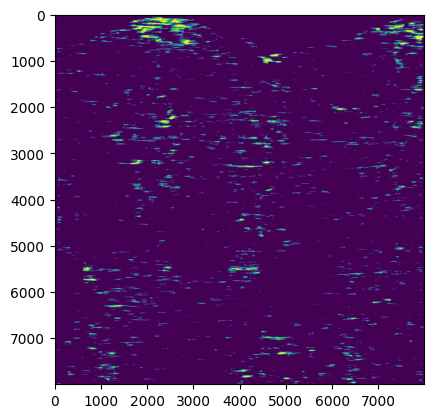

In [59]:
#cv2.imwrite(output_file,np.uint8(inputed*255))
plt.imshow(inputed*255)

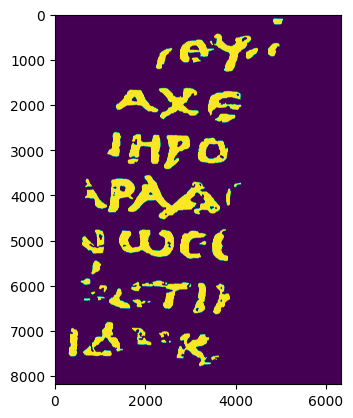

In [99]:
plt.imshow(labeled)

In [100]:
log_excel= "model_logs.xlsx"


In [101]:
current_logs= {}
current_logs["Model_Name"]=[model_path[7:]]
current_logs["Learning_Rate"]= [l_rate]
df_current= pd.DataFrame(current_logs)
df_current

,Model_Name,Learning_Rate
0,model_20231230_183640_6,0.001


In [102]:

if log_excel in os.listdir():
    
    logs= pd.read_excel(log_excel)

else:

    logs=pd.DataFrame()


In [103]:
final_logs= pd.concat([logs,df_current])
final_logs

,Model_Name,Learning_Rate,Validation_Loc
0,model_20231230_112919_0,0.001,500 : 2500
1,model_20231230_141727_1,0.010,500 : 2500
2,model_20231230_150505_1,0.005,500 : 2500
3,model_20231230_150505_1,0.005,NaN
4,model_20231230_160153_3,0.005,NaN
5,model_20231230_160153_3,0.005,NaN
6,model_20231230_164949_4,0.001,NaN
7,model_20231230_174601_4,0.001,NaN
0,model_20231230_183640_6,0.001,NaN


In [104]:
final_logs.to_excel(log_excel,index=False)

True